<a href="https://www.kaggle.com/code/wagerc97/cnn-with-preprocessing-71-30-test-accuracy?scriptVersionId=98375384" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Bird Species Classifier for AML project using Keras/TensorFlow
## University of Vienna, SS 2022

In [24]:
import numpy as np
import pandas as pd
import os
import glob
import time

import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import keras
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image

from sklearn import metrics

In [25]:
print("TensorFlow Version: ", tf.__version__)
print("Keras Version: ", keras.__version__)

TensorFlow Version:  2.6.4
Keras Version:  2.6.0


#### GPU Verfügbarkeit checken

In [26]:
# Source: Tensorflow documentation
gpus = tf.config.list_physical_devices('GPU')
print("GPU list:", gpus)
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

GPU list: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPU


# 1. Der Datensatz

Der Datensatz enthält ca. 60000 gelabelte RGB Bilder der Größe 244x244 Pixel von 400 Vogelspezies. Es gibt jeweils 5 Bilder pro Spezies für Validierungs- und Testset. Der Trainingssatz enthält zwischen 130 und 259 Bildern pro Spezies. Pro Bild wird ein Vogel gezeigt, der mindestens 50% des Bildes einnimmt. Die Datei ```birds.csv``` enthält eine Zusammenfassung der Dateistruktur. Etwa 85% der Bilder zeigen männliche Vögel. 

In [27]:
# Erstelle einen DataFrame aus der CSV Datei
birds_df = pd.read_csv("../input/100-bird-species/birds.csv")
# Spaltennamnen säubern
birds_df.columns = [col.replace(' ', '_').lower() for col in birds_df.columns]
birds_df.head()

,class_index,filepaths,labels,data_set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train


In [28]:
birds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62388 entries, 0 to 62387
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class_index  62388 non-null  int64 
 1   filepaths    62388 non-null  object
 2   labels       62388 non-null  object
 3   data_set     62388 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


In [29]:
birds_df.value_counts("data_set").head()

data_set
train    58388
test      2000
valid     2000
dtype: int64

In [30]:
# Häufigkeit der Vogelarten im gesamten Datensatz
print("| species | f |")
birds_df.value_counts("class_index")

| species | f |


class_index
224    259
144    243
287    243
363    227
396    224
      ... 
129    130
122    130
346    130
326    130
62     130
Length: 400, dtype: int64

In [31]:
# Dateipfade
root_dir = "../input/100-bird-species"
train_dir = "../input/100-bird-species/train"
valid_dir = "../input/100-bird-species/valid"
test_dir = "../input/100-bird-species/test"

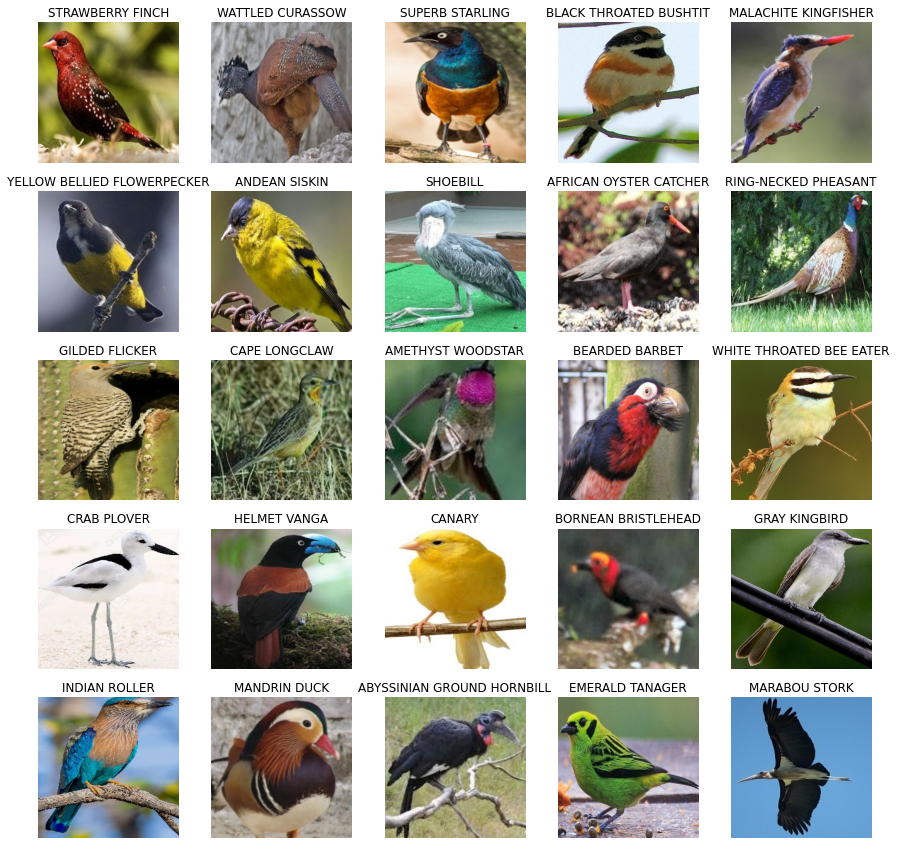

In [32]:
fig, axs = plt.subplots(ncols=5, nrows=5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        sample = birds_df.sample()
        species = sample['labels'].to_string(index=False)
        index = sample.index
        filepath = str(sample.filepaths.values)[2:-2]
        random_bird = mpimg.imread(root_dir + "/" + filepath)
        plt.imshow(random_bird)
        axs[i, j].imshow(random_bird)
        axs[i, j].set_title(species)
        axs[i, j].axis('off')

In [33]:
def show_random_bird(bird_name="MALLARD DUCK"):
    """
    Plot random image of a given species.
    """
    img_files = []
    for img in glob.glob(os.path.join(valid_dir, bird_name)+"/*"):
        img_files.append(img)
    
    index = np.random.randint(0, len(img_files))
    img = PIL.Image.open(str(img_files[index]))
    plt.imshow(img)
    plt.title(bird_name)
    plt.axis('off')
    plt.show()

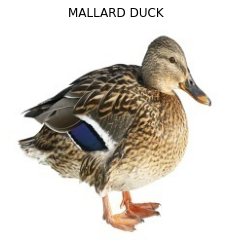

In [34]:
show_random_bird()

# 2. Bilder preprocessen und Datensätze erstellen

**Datensatz balancen:** Nur die ersten 130 Bilder jeder Klasse werden verwendet.

In [35]:
images = []
labels =[]
for root, dirs, files in os.walk(train_dir):
    for i,file in enumerate(files):
        if i<130:
            path_dir = root.split('/')[-1]
            images.append(os.path.join(path_dir, file))
            labels.append(path_dir)
            i+=1
print("images:",len(images))
labels=np.array(labels)
print("labels:",len(np.unique(labels)))

images: 51320
labels: 400


In [36]:
df_train = pd.DataFrame({"Images":images,"Labels":labels})      
df_train = df_train.sample(frac=1).reset_index(drop=True) # Um die Bilder zu shuffeln

**Standardisierung:** Rescaling der Farbwerte und featurewise centering (Mittelwert der Samples = 0) beschleunigt Training und Bilderkennung.   
**Augmentation:** Mit `shear_range` werden die Bilder um den Gegebenen Winkel verzerrt.

In [37]:
IMAGE_SIZE=(224,224)
BATCH_SIZE=32
SEED=42
np.random.seed(42)
tf.random.set_seed(42)

train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    horizontal_flip=True,
    shear_range=0.45
    )
valid_datagen = image.ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    horizontal_flip=True,
    shear_range=0.45
    )
test_datagen = image.ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_dir,
    x_col="Images",
    y_col="Labels",
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    class_mode="categorical",
    target_size=IMAGE_SIZE)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir, 
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42)


class_names = train_generator.class_indices
num_classes = len(class_names)

Found 51320 validated image filenames belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.


# 3. Modell bauen und kompilieren
## Modell Architektur
- 5 Faltungsschichten von 256 bis 16 Neuronen Breite
- 4 Subsampling-Schichten -> Beschleunigung
- Jede Faltungsschicht gefolgt von einer BatchNormalization -> erleichtert Training
- 1 vollvermaschte Schicht -> Pro Label eine Neurone

### Welche layers wurden benutzt?
- **layers.Conv2D() ->** "Faltungsschicht" extrahiert Merkmale 
- **layers.MaxPooling2D() ->** "Subsampling-Schicht" verdichtet und reduziert die Auflösung. Bei **Max**Pooling wird der größte Wert verwendet und der Rest verworfen. Das erhöht die Berechnungsgeschwindigkeit.
- **layers.BatchNormalization() ->** "Chargennormalisierung" wendet eine Transformation an, die den Mittelwert der Ausgabe nahe bei 0 und die Standardabweichung der Ausgabe nahe bei 1 hält.
- **layers.Flatten() ->** formt den 2D Bild Array auf 1D um
- **layers.Dropout() ->** setzt zufällig Werte auf 0 und reduziert die Wahrscheinlichkeit für Overfitting
- **layers.Dense() ->** "Vollvermaschte Schicht", wo die Klassifizierung passiert

In [38]:
INPUT_SHAPE=(224, 224, 3)

model = tf.keras.models.Sequential([

    layers.Input(INPUT_SHAPE),

    # Faltungsschichten -> Merkmale erkennen und extrahieren
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.BatchNormalization(),    

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.BatchNormalization(),    

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), activation='relu'),
    layers.BatchNormalization(),

    # Notwendiger Schritt für die Dense-layer (2D -> 1D)
    layers.Flatten(input_shape=INPUT_SHAPE),
    
    # Overfitting vermeiden
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    
    # Vollvermaschte Schicht -> Klassifizierung
    layers.Dense(units=num_classes, activation='softmax')
])

# Hilft dabei Unordnung aus alten Modellen und Schichten zu entfernen, 
#   besonders wenn nur wenig RAM verfügbar ist.
keras.backend.clear_session()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 256)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 111, 111, 256)     1024      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 128)     295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 54, 54, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        7


## Modell kompilieren
- ``crossentropy`` ist die Standard loss-Funktion für for multi-class Klassifikationsprobleme. ~ [Link](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/#:~:text=Cross%2Dentropy%20is%20the%20default%20loss%20function%20to%20use%20for%20multi%2Dclass%20classification%20problems.)

- WICHTIG: Die Funktion erwartet, dass die output layer n Neuronen hat, wobei n die Anzahl an Klassen ist.  

- Als Aktivierungsfunktion wird die ‘softmax‘ Funktion genommen, um die Wahrscheinlichkeit für jede Klasse vorherzusagen. 

- `Adam` ist ein Standardoptimierer

In [39]:
# Standard Adam Optimierer (unverändert)
opt = optimizers.Adam(
    learning_rate=1e-3,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam',
)

model.compile(
    optimizer=opt,  #'adam',
    loss='categorical_crossentropy', # standard for multi-class clf    
    metrics=['accuracy']
)

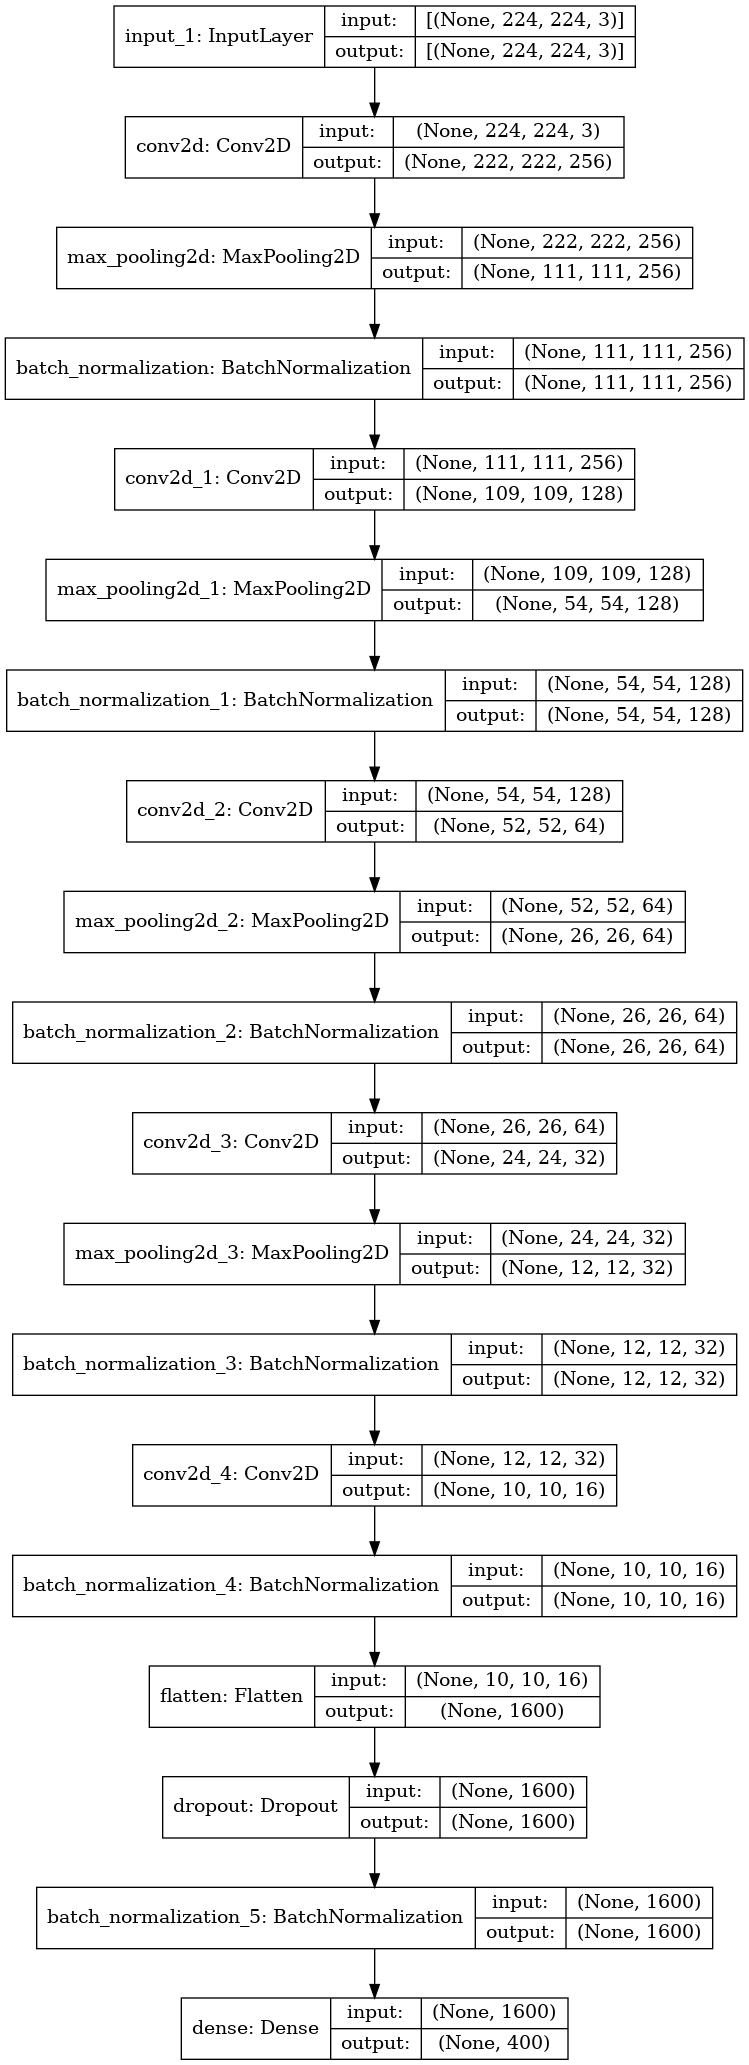

In [40]:
dot_img_file = '/tmp/'+model.name+'.png'
model_img = tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
model_img

# 4. Modell trainieren

In [41]:
def elapsed_seconds_conversion(sec):
    sec_value = sec % (24 * 3600)
    hour_value = sec_value // 3600
    sec_value %= 3600
    min = sec_value // 60
    sec_value %= 60
    print(f"Elapsed time: {hour_value} hours and {min} min")

In [43]:
EPOCHS = 10
STEPS = int(len(valid_generator))
VALIDATION_STEPS = 5
header=f"|Epochs: {EPOCHS} | Validation Steps: {STEPS} | Validations: {VALIDATION_STEPS} |"
stars="\n"+("*"*len(header)); print(header, stars)

starttime = time.time()
preprocessed_hist = model.fit(train_generator,
        validation_data=valid_generator,
        validation_steps=VALIDATION_STEPS, 
        epochs=EPOCHS, 
        workers=-1, verbose=1, callbacks=[
        tf.keras.callbacks.EarlyStopping( 
            #Prevent overfitting through early stopping
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=1)
        ])
stoptime = time.time()

|Epochs: 10 | Validation Steps: 63 | Validations: 5 | 
*****************************************************
Epoch 1/10
1604/1604 [==============================] - 966s 602ms/step - loss: 4.1345 - accuracy: 0.2080 - val_loss: 2.3739 - val_accuracy: 0.4688
Epoch 2/10
1604/1604 [==============================] - 727s 453ms/step - loss: 2.7076 - accuracy: 0.4141 - val_loss: 2.5657 - val_accuracy: 0.4750
Epoch 3/10
1604/1604 [==============================] - 724s 451ms/step - loss: 2.1687 - accuracy: 0.5147 - val_loss: 1.7195 - val_accuracy: 0.6250
Epoch 4/10
1604/1604 [==============================] - 722s 450ms/step - loss: 1.8621 - accuracy: 0.5708 - val_loss: 1.4808 - val_accuracy: 0.6562
Epoch 5/10
1604/1604 [==============================] - 719s 448ms/step - loss: 1.6699 - accuracy: 0.6082 - val_loss: 1.5267 - val_accuracy: 0.6938
Epoch 6/10
1604/1604 [==============================] - 729s 455ms/step - loss: 1.5167 - accuracy: 0.6398 - val_loss: 0.9315 - val_accuracy: 0.7625
Epo

In [44]:
# Trainingszeit
elapsed_seconds_conversion(stoptime-starttime)

Elapsed time: 2.0 hours and 6.0 min


# 5. Evaluation
### Final validation score

In [56]:
scores = model.evaluate(valid_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

model_save_name = "model/Model_" + str(time.strftime("%Y-%m-%d_%H:%M:%S")) + f"[{round(scores[1]*100,2)}%]" + ".h5"
model.save(model_save_name)

63/63 [==============================] - 25s 389ms/step - loss: 1.3969 - accuracy: 0.6790
Accuracy: 67.90%


### Training Visualisieren

loss-acc_2022-06-14_19-48-23[67.7%].png


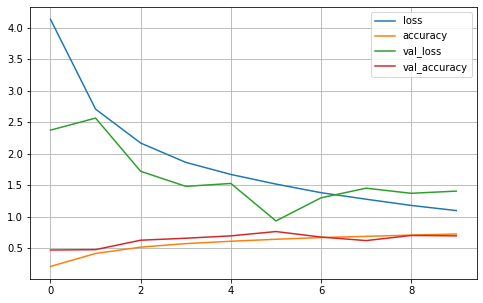

In [54]:
pd.DataFrame(preprocessed_hist.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plot_name = "loss-acc_"+ str(time.strftime("%Y-%m-%d_%H-%M-%S")) + f"[{round(scores[1]*100,2)}%]" + ".png"
print(plot_name)
plt.savefig(plot_name)
plt.show()

acc_2022-06-14_19-48-38[67.7%].png


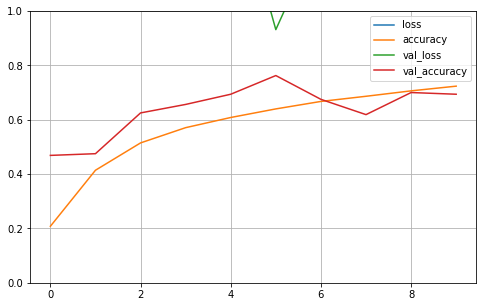

In [55]:
pd.DataFrame(preprocessed_hist.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plot_name = "acc_"+ str(time.strftime("%Y-%m-%d_%H-%M-%S")) + f"[{round(scores[1]*100,2)}%]" + ".png"
print(plot_name)
plt.savefig(plot_name)
plt.show()

## Gespeichertes Modell reinladen und genauer evaluieren

In [48]:
model = keras.models.load_model(model_save_name)

### Final test score

In [49]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

63/63 [==============================] - 17s 266ms/step - loss: 1.2036 - accuracy: 0.7130
Accuracy: 71.30%


---

### Additional classification report

In [50]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = model.predict(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

In [51]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [57]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

                             precision    recall  f1-score   support

            ABBOTTS BABBLER       0.00      0.00      0.00         5
              ABBOTTS BOOBY       0.00      0.00      0.00         5
 ABYSSINIAN GROUND HORNBILL       0.00      0.00      0.00         5
      AFRICAN CROWNED CRANE       0.00      0.00      0.00         5
     AFRICAN EMERALD CUCKOO       0.00      0.00      0.00         5
          AFRICAN FIREFINCH       0.00      0.00      0.00         5
     AFRICAN OYSTER CATCHER       0.00      0.00      0.00         5
                  ALBATROSS       0.00      0.00      0.00         5
             ALBERTS TOWHEE       0.00      0.00      0.00         5
       ALEXANDRINE PARAKEET       0.00      0.00      0.00         5
              ALPINE CHOUGH       0.00      0.00      0.00         5
      ALTAMIRA YELLOWTHROAT       0.00      0.00      0.00         5
            AMERICAN AVOCET       0.00      0.00      0.00         5
           AMERICAN BITTERN      

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
